In [32]:
#Importing necessary libraries
import zipfile
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [65]:
#extracting the dataset from a zip file
zip_path = "/content/Package_images.zip"
extract_path = "/content/packages_dataset_new/Package_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [66]:
#Creating 2 folders based on views
top_folder = os.path.join(extract_path, "top_view")
side_folder = os.path.join(extract_path, "side_view")


In [78]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Paths
base_dir = "packages_dataset_new/Package_images"
top_view_dir = os.path.join(base_dir, "top_view")
side_view_dir = os.path.join(base_dir, "side_view")

# Parameters
img_size = (128, 128)

# Function to load images from a folder
def load_images_from_folder(folder, img_size):
    images = []
    labels = [] # Initialize labels list here
    for filename in sorted(os.listdir(folder)):  # sorting to maintain order
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, filename)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # normalize
            images.append(img_array)
            # Assuming label is embedded in the filename, e.g., "damaged_001.jpg" or "intact_001.jpg"
            label = 1 if "damaged" in filename.lower() else 0 # 1 for damaged, 0 for intact
            labels.append(label) # Append label for each image

    return images, labels # Return both images and labels

# Load top view images and labels
top_damaged_images, top_damaged_labels = load_images_from_folder(os.path.join(top_view_dir, "damaged"), img_size)
top_intact_images, top_intact_labels = load_images_from_folder(os.path.join(top_view_dir, "intact"), img_size)

# Load side view images and labels
side_damaged_images, side_damaged_labels = load_images_from_folder(os.path.join(side_view_dir, "damaged"), img_size)
side_intact_images, side_intact_labels = load_images_from_folder(os.path.join(side_view_dir, "intact"), img_size)

# Combine top and side views
X_top = np.array(top_damaged_images + top_intact_images)
X_side = np.array(side_damaged_images + side_intact_images)

# Combine labels, ensuring they match the combined images
y = np.array(top_damaged_labels + top_intact_labels) # Labels should be the same for top and side views

In [79]:
print(X_top.shape)
print(X_side.shape)

(200, 128, 128, 3)
(200, 128, 128, 3)


In [80]:
from tensorflow.keras.utils import to_categorical

# Ensure y is a numpy array before one-hot encoding
y_encoded = to_categorical(y, num_classes=2)
print("One-Hot Encoded Labels Shape:", y_encoded.shape)

One-Hot Encoded Labels Shape: (200, 2)


In [81]:
print(y_encoded.shape)

(200, 2)


In [102]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate

# Image size and number of classes
img_size = (128, 128, 3)
num_classes = y_encoded.shape[1]  # from your one-hot encoding

# ------------------- First CNN (Top View) -------------------
input_top = Input(shape=img_size)

x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_top)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Flatten()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.5)(x1)

# ------------------- Second CNN (Side View) -------------------
input_side = Input(shape=img_size)

x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_side)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)

x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)

x2 = Flatten()(x2)
x2 = Dense(128, activation='relu')(x2)
x2 = Dropout(0.5)(x2)

# ------------------- Merge Both Branches -------------------
merged = concatenate([x1, x2])
dense = Dense(128, activation='relu')(merged)
output = Dense(num_classes, activation='softmax')(dense)

# ------------------- Define Model -------------------
model = Model(inputs=[input_top, input_side], outputs=output)

# ------------------- Compile Model -------------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 64, 64,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_26… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 32, 32,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 65536)     │          0 │ max_pooling2d_25… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 65536)     │          0 │ max_pooling2d_27… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │  8,388,736 │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │  8,388,736 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256)       │          0 │ dropout_12[0][0], │
│ (Concatenate)       │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,849,410 (64.28 MB)

 Trainable params: 16,849,410 (64.28 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_top)
datagen.fit(X_side)


In [104]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential # Import Sequential


# Example in CNN branch
model_top = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Dropout(0.3),  # Add dropout
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Flatten()
])

In [105]:
from tensorflow.keras.regularizers import l2

Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001))


<Conv2D name=conv2d_32, built=False>

In [107]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)




In [108]:
history = model.fit([X_top, X_side], y_encoded, epochs=20, batch_size=32, validation_split=0.2,callbacks=[early_stop])


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


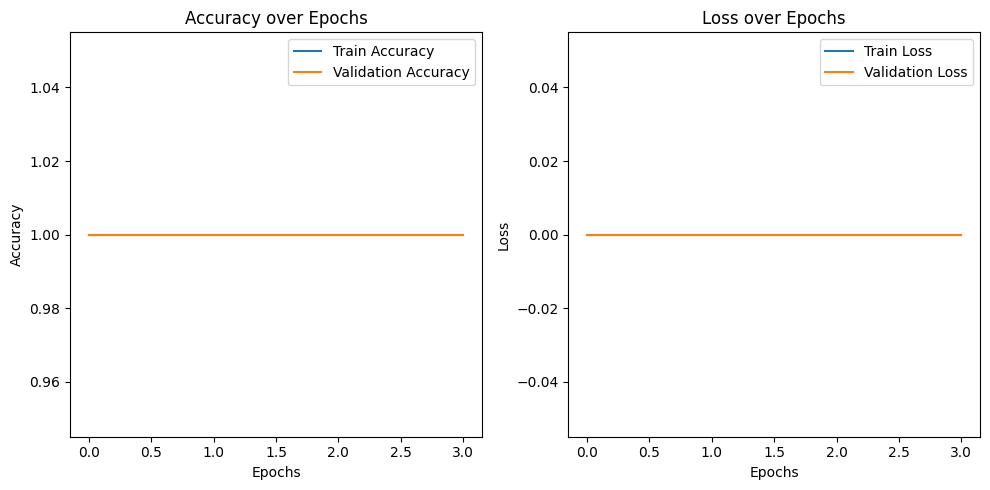

In [109]:
import matplotlib.pyplot as plt
# Plot Accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [110]:
model.save("quality_control_package_inspection.h5")


In [91]:
import zipfile
import os
from google.colab import files

# Specify the directory to zip
directory_to_zip = "/content/packages_dataset_new"

# Specify the name for the output zip file
output_zip_file = "pre-processed_packages_dataset_new.zip"

# Create a ZipFile object in write mode
with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory and add all files to the zip file
    for root, _, files in os.walk(directory_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            # Add file to zip, preserving the directory structure
            zipf.write(file_path, os.path.relpath(file_path, directory_to_zip))

print(f"Successfully created {output_zip_file}")



Successfully created pre-processed_packages_dataset_new.zip


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_top_train, X_top_val, X_side_train, X_side_val, y_train, y_val = train_test_split(
    X_top, X_side, y_encoded, test_size=0.2, random_state=42
)

print("Training data shapes:")
print("X_top_train:", X_top_train.shape)
print("X_side_train:", X_side_train.shape)
print("y_train:", y_train.shape)

print("\nValidation data shapes:")
print("X_top_val:", X_top_val.shape)
print("X_side_val:", X_side_val.shape)
print("y_val:", y_val.shape)